/home/hamid/dev/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:84: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


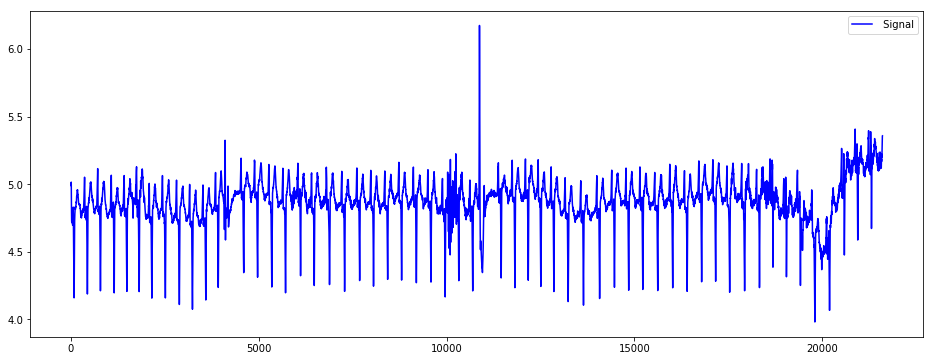

In [102]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
   
    
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except   Exception as e:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

df = pd.read_csv('resources/mitdbx_mitdbx_108.txt', sep="  ", header = None)
df.columns = ["timeStamp", "MLII", "V2"]
df.drop(['timeStamp', "V2"], 1, inplace=True)
data = savitzky_golay(np.array(df["MLII"]), 11, 3)

fig = plt.gcf()
fig.set_size_inches(16, 6)
plt.plot(data,'b', label=' Signal')
plt.legend()
plt.show()
df["MLII"] =data


min_max_scaler = preprocessing.MinMaxScaler()
#This transformation is often used as an alternative to zero mean, unit variance scaling.
#reshape with (-1, 1) . We have provided column as 1 but rows as unknown . So we get result new shape as (m*n, 1).

df["MLII"] = min_max_scaler.fit_transform(df["MLII"].values.reshape(-1,1))



In [84]:

import keras
model = Sequential()
d = 0.3
decay=0.2
model.add(LSTM(64, input_shape=(50, 1), return_sequences=True))
model.add(Dropout(d))

model.add(LSTM(64, input_shape=(50, 1), return_sequences=False))
model.add(Dropout(d))

model.add(Dense(64,kernel_initializer="uniform",activation='relu'))
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
adam = keras.optimizers.Adam(decay=decay)
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 64)            16896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


In [88]:
seq_len = 50
def load_data(df, seq_len):
    amount_of_features = len(df.columns)
    data = df.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length):  
        result.append(data[index: index + sequence_length])  

    result = np.array(result)
    row = round(0.7 * result.shape[0]) # 70% split

    train = result[:int(row), :] # 70% 
    X_train = train[:, :-1] #  
    y_train = train[:, -1][:,-1] #  

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = load_data(df, seq_len )
#print (X_train[0], y_train[0])


print(X_train[0].shape)
model.fit(
                X_train, y_train,
                batch_size=512, epochs=50, validation_split=0.1)

(50, 1)
Train on 13575 samples, validate on 1509 samples
Epoch 1/50
13575/13575 [==============================] - 13s - loss: 0.0019 - acc: 7.3665e-05 - val_loss: 7.9931e-04 - val_acc: 0.0000e+00

In [89]:
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

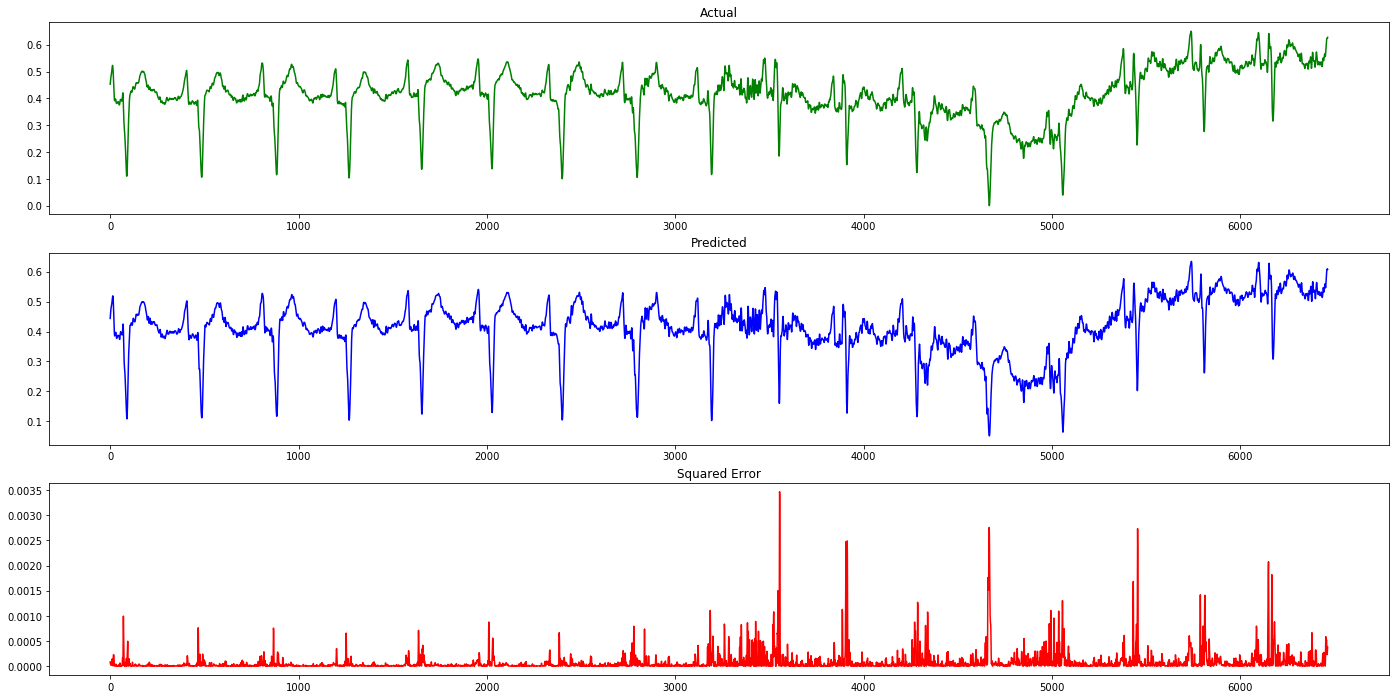

In [103]:
fig = plt.gcf()
fig.set_size_inches(24, 12)
plt.figure(1)
plt.subplot(311)
plt.title("Actual")
plt.plot(y_test[:len(y_test)], 'g')
plt.subplot(312)
plt.title("Predicted")
plt.plot(predicted[:len(y_test)], 'b')
plt.subplot(313)
plt.title("Squared Error")
mse = ((y_test - predicted) ** 2)
plt.plot(mse, 'r')
plt.show()

